<a href="https://colab.research.google.com/github/BonaldSo/project_cnn/blob/main/MyCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.optim import Optimizer
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from typing import Tuple

In [ ]:
def verify_conv2d():
    x = torch.randn(1, 3, 32, 32)
    in_channels = 3
    out_channels = 16
    kernel_size = 3
    stride = 1
    padding = 1


    conv_pytorch = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    output_pytorch = conv_pytorch(x)

    conv_custom = Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    conv_custom.weight.data = conv_pytorch.weight.data.clone()
    conv_custom.bias.data = conv_pytorch.bias.data.clone()
    output_custom = conv_custom(x)
    difference = (output_pytorch - output_custom).abs().max()
    return (difference < 1e-06).item()

In [ ]:
@torch.no_grad
def verify_dropout():
    p = 0.8
    n = int(1e5)
    x = torch.randn(5)
    weight = torch.randn(5)

    y = torch.dot(x, weight)
    print('x dot product weight', y)

    dropout_pytorch = nn.Dropout(p)
    dropout_custom = Dropout(p)

    dropout_pytorch.eval()
    dropout_custom.eval()

    output_pytorch = torch.dot(weight, dropout_pytorch(x))
    output_custom = torch.dot(weight, dropout_custom(x))
    assert torch.allclose(output_pytorch, output_custom), "The outputs are not the same in evaluation mode."

    dropout_pytorch.train()
    dropout_custom.train()

    pytorch_dropout_train = torch.zeros_like(output_pytorch)
    custom_dropout_train = torch.zeros_like(output_custom)

    for _ in range(n):
        x_hat = dropout_pytorch(x)
        pytorch_dropout_train += torch.dot(x_hat, weight)
        x_hat = dropout_custom(x)
        custom_dropout_train += torch.dot(x_hat, weight)

    pytorch_dropout_train /= n
    custom_dropout_train /= n

    print('Empirical mean of Pytorch Dropout result', pytorch_dropout_train)
    print('Empirical mean of Custom Dropout result', custom_dropout_train)

In [ ]:
@torch.no_grad
def verify_batchnorm():
    x = torch.randn(2, 3, 4, 4)

    num_features = x.shape[1]

    custom_bn = BatchNorm2d(num_features, eps=1e-5, momentum=0.1)
    pytorch_bn = nn.BatchNorm2d(num_features, eps=1e-5, momentum=0.1)

    pytorch_bn.weight.data = custom_bn.weight.data.clone()
    pytorch_bn.bias.data = custom_bn.bias.data.clone()
    pytorch_bn.running_mean = custom_bn.running_mean.clone()
    pytorch_bn.running_var = custom_bn.running_var.clone()

    custom_bn.train()
    pytorch_bn.train()

    output_custom = custom_bn(x)
    output_pytorch = pytorch_bn(x)
    difference = (output_custom - output_pytorch).abs().max()
    return (difference < 1e-06).item()

In [ ]:
@torch.no_grad
def eval_accuracy(model, eval_loader, device):
    model.eval()
    n_correct = 0
    n_total = 0
    for imgs, labels in eval_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        _, pred = torch.max(logits, 1)

        n_correct += (pred == labels).sum().item()
        n_total += len(labels)

    return n_correct / n_total

In [ ]:
def plot_curves(train_error_rates, val_error_rates):
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_error_rates) + 1)
    plt.plot(epochs, train_error_rates, 'bo-', label='Training Error')
    plt.plot(epochs, val_error_rates, 'ro-', label='Validation Error')
    plt.title('Training and Validation Error Rates')
    plt.xlabel('Epochs')
    plt.ylabel('Error Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

def show_batch(data_loader):
    dataiter = iter(train_loader)
    images, labels = next(dataiter)
    fig = plt.figure(figsize=(25, 4))
    for idx in range(20):
        ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
        imshow(images[idx])
        ax.set_title(classes[labels[idx]])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(2024)

In [ ]:
batch_size = 128

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, 4),
    transforms.ToTensor(),
    normalize,
])


train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:04<00:00, 42518232.41it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
def build_loaders(train_data: torch.utils.data.Dataset,
                  test_data: torch.utils.data.Dataset,
                  train_ratio: float=0.8,
                  val_ratio: float=0.2,
                  batch_size:int=batch_size) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """
    Args:
    - train_data: CIFAR-10 train data
    - test_data: CIFAR-10 test data
    - train_ratio: ratio of training
    - val_ratio: ratio of validation
    - batch_size: Batch size
    Returns:
    - train_loader: Dataloader for training
    - val_loader: Dataloader for validation
    - test_loader: Dataloader for test
    """
    # TODO: Random split CIFAR-10 train-validation sets
    # TODO: Return train/val/test loaders
    train = int(train_ratio * len(train_data))
    val = len(train_data) - train
    traind, vald = random_split(train_data, [train, val])
    trl = DataLoader(traind, batch_size=batch_size, shuffle=True)
    vl = DataLoader(vald, batch_size=batch_size, shuffle=True)
    tel = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    return trl, vl, tel


In [ ]:
train_loader, val_loader, test_loader = build_loaders(train_data, test_data)

### Visualize a Batch of Training Data

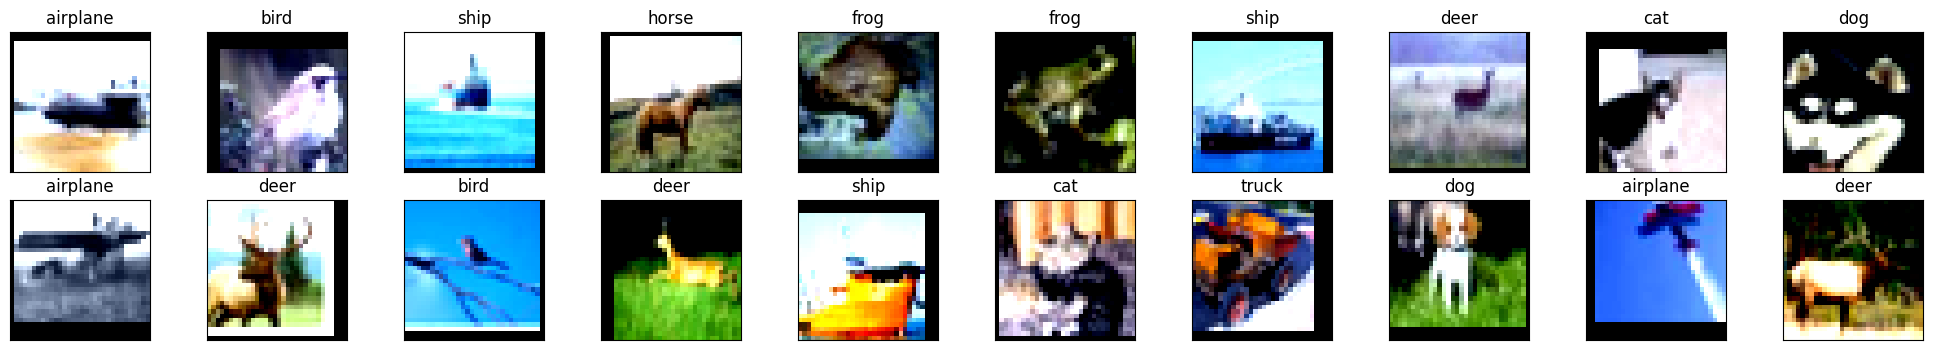

In [ ]:
show_batch(train_loader)

In [ ]:
class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(Conv2d, self).__init__()

        assert in_channels > 0 and out_channels > 0 and kernel_size > 0
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.weight = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))
        self.bias = nn.Parameter(torch.randn(out_channels))

    def forward(self, x):
        """
        Args:
        - x: input tensor
        Returns:
        - output: convoluted tensor
        """
        # TODO: 2D cross-correlation operator
        bsize, _, inheight, inwidth = x.size()
        outc, inc, kheight, kwidth = self.weight.size()
        outheight = (inheight + 2 * self.padding - kheight) // self.stride + 1
        outwidth = (inwidth + 2 * self.padding - kwidth) // self.stride + 1

        xpad = nn.functional.pad(x, (self.padding, self.padding, self.padding, self.padding))
        output = torch.zeros(bsize, outc, outheight, outwidth)
        for b in range(0, bsize):
            for c in range(0, outc):
                for i in range(0, inheight):
                    for j in range(0, inwidth):
                        patch = xpad[b, :, i * self.stride: i * self.stride + kheight, j * self.stride: j * self.stride + kwidth]
                        output[b, c, i, j] = torch.sum(patch * self.weight[c]) + self.bias[c]
        return output



In [ ]:
conv2d_passed = verify_conv2d()
print('Passed conv2d test:', conv2d_passed)

Passed conv2d test: True


In [ ]:
class Dropout(nn.Module):
    def __init__(self, p):
        super(Dropout, self).__init__()
        """
        Args:
        - p: dropout rate
        """
        assert p >= 0 and p <= 1
        self.p = p

    def forward(self, x):
        """
        Args:
        - x: input tensor
        Returns:
        - output: dropout tensor
        """
        # TODO: Dropout layer
        output = x.clone()
        if self.training:
            mask = (torch.rand_like(output) > self.p).float()
            return mask * output / (1.0 - self.p)
        else:
            return output



In [ ]:
verify_dropout()

x dot product weight tensor(-1.7168)
Empirical mean of Pytorch Dropout result tensor(-1.7178)
Empirical mean of Custom Dropout result tensor(-1.7170)


In [ ]:
class BatchNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(BatchNorm2d, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum

        self.weight = nn.Parameter(torch.ones(num_features))
        self.bias = nn.Parameter(torch.zeros(num_features))

        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var', torch.ones(num_features))

        self.reset_parameters()

    def reset_parameters(self):
        self.running_mean.zero_()
        self.running_var.fill_(1)
        nn.init.uniform_(self.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        if self.training:
            # TODO: BatchNorm2d in training.
            batch_mean = x.mean([0, 2, 3], keepdim=True)
            batch_var = x.var([0, 2, 3], keepdim=True, unbiased=False)

            # Update running statistics without in-place operations
            self.running_mean = (1 - self.momentum) * self.running_mean.detach() + self.momentum * batch_mean.detach().squeeze()
            self.running_var = (1 - self.momentum) * self.running_var.detach() + self.momentum * x.var([0, 2, 3], keepdim=True, unbiased=True).detach().squeeze()
            # Thanks for correction in Piazza.

            x = (x - batch_mean) / torch.sqrt(batch_var + self.eps)

            pass
        else:
            x = (x - self.running_mean.view(1, self.num_features, 1, 1)) / \
                (self.running_var.view(1, self.num_features, 1, 1) + self.eps).sqrt()

        x = x * self.weight.view(1, self.num_features, 1, 1) + self.bias.view(1, self.num_features, 1, 1)
        return x


In [ ]:
passed = verify_batchnorm()
print('Customize BatchNormalization 2d passed: ', passed)

Customize BatchNormalization 2d passed:  True


In [ ]:
def cross_entropy(logits, labels):
    """
    Args:
    - logits: Tensor of logits (shape: [batch_size, num_classes]).
    - labels: LongTensor of labels (shape: [batch_size]).

    Returns:
    - loss: the mean cross entropy loss.
    """
    if not labels.dtype == torch.long:
        raise ValueError("Labels dtype should be torch.long")

    # TODO: Cross-Entropy Loss
    sm = torch.nn.functional.softmax(logits, dim=1)
    p = torch.gather(sm, 1, labels.view(-1, 1))
    loss = -torch.log(p).mean()
    return loss

In [ ]:
class SGD(Optimizer):
    def __init__(self, params, lr=0.01):
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr)
        super(SGD, self).__init__(params, defaults)

    def step(self, closure=None):
        """
        Performs a single optimization step (parameter update).

        Args:
            closure (callable, optional): A closure that re-evaluates the model
                and returns the loss. This is useful for certain types of
                optimization algorithms that require re-evaluation of the loss.
                For simple SGD, this is not typically used, i.e., closure=None.

        Returns:
            The loss returned by the closure if it is provided; otherwise, None.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                # TODO: SGD
                # Using SGD update rule for updating p.data
                p.data = p.data - group['lr'] * p.grad

        return loss

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()

        # TODO: initial CNN
        self.conv1 = nn.Conv2d(3, 16, kernel_size = 2, padding = 1)
        self.batch1 = BatchNorm2d(16)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size = 2, padding = 1)
        self.batch2 = BatchNorm2d(32)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size = 2, padding = 1)
        self.batch3 = BatchNorm2d(64)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size = 2, stride = 2)

        input_dim = 64 * 4 * 4
        hidden_dim = 512
        num_classes = 10
        p=0.25

        self.classifier = nn.Linear(input_dim, hidden_dim)
        self.reluc = nn.ReLU()
        self.dropc = Dropout(p)
        self.outc = nn.Linear(hidden_dim, num_classes)



    def forward(self, x):
        # TODO: feedforward function for CNN
        x = self.conv1(x)
        x = self.batch1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.batch2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.batch3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        x = self.reluc(x)
        x = self.dropc(x)
        x = self.outc(x)

        return x


In [ ]:
n_epochs = 50
eval_interval = 10
model = SimpleCNN()
model.to(device)
optimizer = SGD(model.parameters(), lr = 0.01)
min_error = 1.0
train_error_rates, val_error_rates = [], []
running_loss, running_steps = 0., 0

for epoch in tqdm(range(1, n_epochs + 1)):
    model.train()
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        optimizer.zero_grad()
        loss = cross_entropy(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_steps += 1

    if epoch % eval_interval == 0:
        train_error = 1 - eval_accuracy(model, train_loader, device)
        val_error = 1 - eval_accuracy(model, val_loader, device)
        train_error_rates.append(train_error)
        val_error_rates.append(val_error)

        # Append your error rates for plotting

        print('Epoch: %d' % epoch)
        print('Average training loss: %.3f' % (running_loss / running_steps))
        print('Current validation error rate: %.3f' % (val_error * 100.0))
        running_loss, running_steps = 0., 0
        if val_error < min_error:
            print('Val error rate is decreasing: {%.2f%%} -> {%.2f%%}' % (min_error * 100.0, val_error * 100.0))
            torch.save(model.state_dict(), 'model_parameters.pth')
            print('Model saved')

        min_error = min(val_error, min_error)


 20%|██        | 10/50 [03:37<17:24, 26.12s/it]

Epoch: 10
Average training loss: 1.496
Current validation error rate: 45.220
Val error rate is decreasing: {100.00%} -> {45.22%}
Model saved


 40%|████      | 20/50 [07:13<12:59, 25.98s/it]

Epoch: 20
Average training loss: 1.164
Current validation error rate: 39.170
Val error rate is decreasing: {45.22%} -> {39.17%}
Model saved


 60%|██████    | 30/50 [10:46<08:36, 25.81s/it]

Epoch: 30
Average training loss: 1.017
Current validation error rate: 34.840
Val error rate is decreasing: {39.17%} -> {34.84%}
Model saved


 80%|████████  | 40/50 [14:18<04:16, 25.70s/it]

Epoch: 40
Average training loss: 0.929
Current validation error rate: 32.160
Val error rate is decreasing: {34.84%} -> {32.16%}
Model saved


100%|██████████| 50/50 [17:52<00:00, 21.45s/it]

Epoch: 50
Average training loss: 0.862
Current validation error rate: 31.060
Val error rate is decreasing: {32.16%} -> {31.06%}
Model saved


In [ ]:
model.load_state_dict(torch.load('model_parameters.pth'))
test_acc = eval_accuracy(model, test_loader, device)
print('Test accuracy = %.2f%%' % (test_acc * 100))

Test accuracy = 69.19%


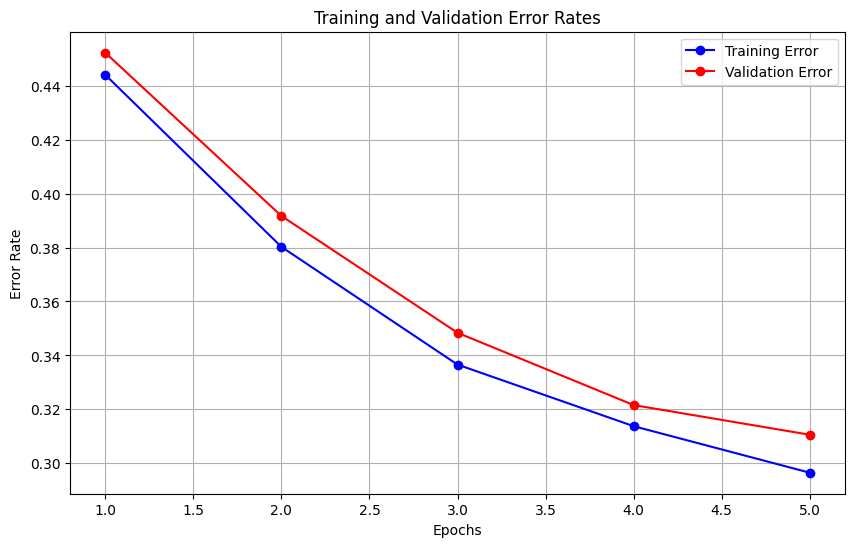

In [ ]:
plot_curves(train_error_rates, val_error_rates)